# Usage De Sol Par Classification Supervisée (Imagerie Sentinel 2) 

Un analyste qui tente de classer les caractéristiques d'une image, utilise les éléments de l'interprétation visuelle pour identifier des groupes homogènes de pixels qui représentent des classes intéressantes de surfaces. La classification numérique des images utilise l'information spectrale contenue dans les valeurs d'une ou de plusieurs bandes spectrales pour classifier chaque pixel individuellement. Ce type de classification est appelé reconnaissance de regroupements spectraux. Les deux façons de procéder (manuelle ou automatique) ont pour but d'assigner une classe particulière ou thème (par exemple : eau, forêt de conifères, maïs, blé, etc.) à chacun des pixels d'une image. La "nouvelle" image qui représente la classification est composée d'une mosaïque de pixels qui appartiennent chacun à un thème particulier. Cette image est essentiellement une représentation thématique de l'image originale.

Nous allons suivre les étapes suivantes:

0. Prétraitement sur Qgis

1. Import des modules *(libraries)* nécessaires

2. Import des zones de vérité terrain + Transformation + Division en Train/Test 

3. Entrainement du modèle

4. Evaluation de la performance

5. Résultat final

6. Discussion

## Prétraitement sur Qgis

Après préparation des bandes qui nous intéresse (R, G, B, NIR), on crée des shapefiles qui vont être nos AOIs (Areas Of Interest) en s’aidant d’une **visualisation en couleur vrai**. Ces AOIs vont servir pour entrainer notre modèle et le tester également.

<img src="./img/Screenshot 2021-11-23 182245.png">

## Import des modules *(libraries)* nécessaires 

Les **modules** que nous allons utiliser sont les suivants:

* **numpy**: NumPy est très utile pour effectuer des opérations mathématiques et logiques sur des tableaux. Il fournit une abondance de fonctionnalités utiles pour les opérations sur n-arrays et matrices en Python ...

* **pandas**: pandas est un outil d'analyse et de manipulation de données open source rapide, puissant, flexible et facile à utiliser, construit sur le langage de programmation Python.

* **matplotlib**: Matplotlib est une bibliothèque complète permettant de créer des visualisations statiques, animées et interactives en Python. Matplotlib rend les choses faciles faciles et les choses difficiles possibles.

* **rasterio**: Les systèmes d'information géographique utilisent GeoTIFF et d'autres formats pour organiser et stocker des ensembles de données matricielles maillées, comme des images satellite et des modèles de terrain. Rasterio lit et écrit ces formats et fournit une API Python basée sur des tableaux Numpy à N dimensions et GeoJSON.

* **sklearn**: Scikit-learn est une bibliothèque libre d'apprentissage automatique pour le langage de programmation Python. Elle propose divers algorithmes de classification, de régression et de regroupement, notamment les machines à vecteurs de support, les forêts aléatoires, le gradient boosting, les k-means et DBSCAN, et est conçue pour interagir avec les bibliothèques numériques et scientifiques Python NumPy et SciPy. Scikit-learn est un projet NumFOCUS parrainé fiscalement.

* **seaborn**: Seaborn est une bibliothèque Python de visualisation de données basée sur matplotlib. Elle fournit une interface de haut niveau pour dessiner des graphiques statistiques attrayants et informatifs.

In [1]:
import rasterio
import rasterio.features
import rasterio.warp
import matplotlib.pyplot as plt
from rasterio.plot import show
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import seaborn as sns

## Import des zones de vérité terrain

Concernant les zones connus, elles sont extraites des shapefiles créés au début, donc pour chaque classe on aura les valeurs radiométriques des 4 bandes de ces pixels affectés par le superviseur.

* Eau **(0)**

In [2]:
eau_ = rasterio.open("./train-test-data/WATER_.tif")

#Lire l'image 
array_ea = eau_.read()
#creation d'array numpy
array_ea = np.array(array_ea)

eau = pd.DataFrame(array_ea.reshape([4,-1]).T)
eau = eau[eau[0] != 0]
eau['target'] = 0

* Vegetation **(1)**

In [3]:
vegetation_ = rasterio.open("./train-test-data/VEGETATION_.tif")

#Lire l'image 
array_vg = vegetation_.read()
#creation d'array numpy
array_vg = np.array(array_vg)

vegetation = pd.DataFrame(array_vg.reshape([4,-1]).T)
vegetation = vegetation[vegetation[0] != 0]
vegetation['target'] = 1

* Terrain nu **(2)**

In [4]:
bareland_ = rasterio.open("./train-test-data/BARELAND_.tif")

#Lire l'image 
array_bl = bareland_.read()
#creation d'array numpy
array_bl = np.array(array_bl)

bareland = pd.DataFrame(array_bl.reshape([4,-1]).T)
bareland = bareland[bareland[0] != 0]
bareland['target'] = 2

* Urbain **(3)**

In [5]:
urbain_ = rasterio.open("./train-test-data/URBAN_.tif")

#Lire l'image 
array_ur = urbain_.read()
#creation d'array numpy
array_ur = np.array(array_ur)

urbain = pd.DataFrame(array_ur.reshape([4,-1]).T)
urbain = urbain[urbain[0] != 0]
urbain['target'] = 3

In [6]:
frames = [eau,vegetation, urbain, bareland]

data = pd.concat(frames)

## Entrainement du modèle

In [7]:
X = data.drop("target", axis=1)
y = data["target"]

# scaler = StandardScaler().fit(X)
# X_scaled = scaler.transform(X)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [8]:
# K-NNC
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

# Predict the labels of test data
knn_pred = knn.predict(X_test)

## Evaluation de la performance

In [9]:
print(f"Accuracy (Précision): {accuracy_score(y_test, knn_pred)*100}")
print("-------------------------------------------")
print(classification_report(y_test, knn_pred))

Accuracy (Précision): 99.56912357902456
-------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8905
           1       0.99      1.00      0.99       576
           2       0.99      1.00      0.99      5598
           3       1.00      0.99      0.99      6737

    accuracy                           1.00     21816
   macro avg       0.99      1.00      0.99     21816
weighted avg       1.00      1.00      1.00     21816



(0) Eau
(1) Végétation
(2) Terrain nu
(3) Urbain)


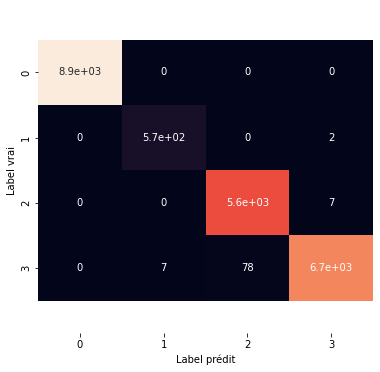

In [10]:
# Create a confusion matrix using the confusion_matrix function
confusion_matrix(y_test, knn_pred)
# Import seaborn for improving visualisation of confusion matrix

# Make confusion matrix more visual
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("Label prédit")
    plt.ylabel("Label vrai")
    
    # Fix the broken annotations (this happened in Matplotlib 3.1.1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    
    print("(0) Eau\n(1) Végétation\n(2) Terrain nu\n(3) Urbain)")
    
plot_conf_mat(y_test, knn_pred)

**COEFFICIENT KAPPA**

In [11]:
cohen_kappa_score(y_test, knn_pred)

0.9935854151712521

## Résultat final

In [12]:
src = rasterio.open('./train-test-data/4BANDS-SOURCE.tif')
#Lire l'image 
array = src.read()

#creation d'array numpy
array = np.array(array)

sentinel2 = pd.DataFrame(array.reshape([4,-1]).T)

In [13]:
full = knn.predict(sentinel2)

In [14]:
full = full.reshape([1 ,3527, 2996])

In [15]:
profile = src.profile
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

with rasterio.open('./out/output-1.tif', 'w', **profile) as dst:
    dst.write(full.astype(rasterio.uint8))

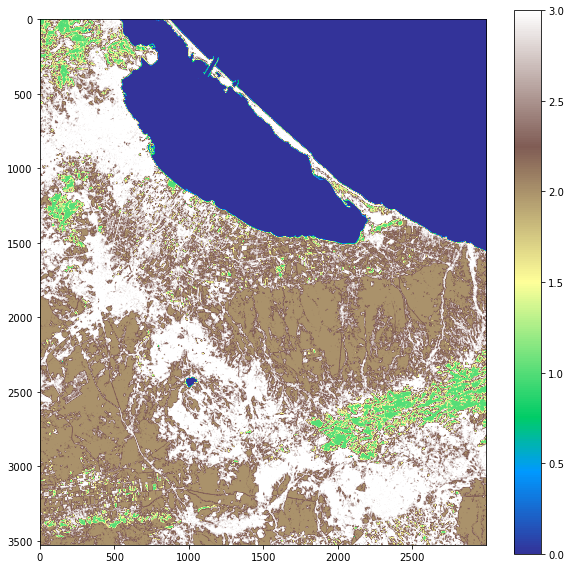

In [16]:
#open the raster
src=rasterio.open('./out/output-1.tif')

#display one band:
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(src.read(1), cmap='terrain')
fig.colorbar(img, ax=ax)

## Discussion

En constatant l’image de sortie classifié il est clair que notre algorithme :

* **a bien classifié tout ce qui relève de l’hydrographie**

* **a raté quelque zone de végétation**

* **fait une grande confusion entre l'urbain et le terrain nu**


Ce que nous allons explorer dans ce qui suit.

### Exploration des meilleurs hyperparamètres relative à l'algorithme de KNN utilisé

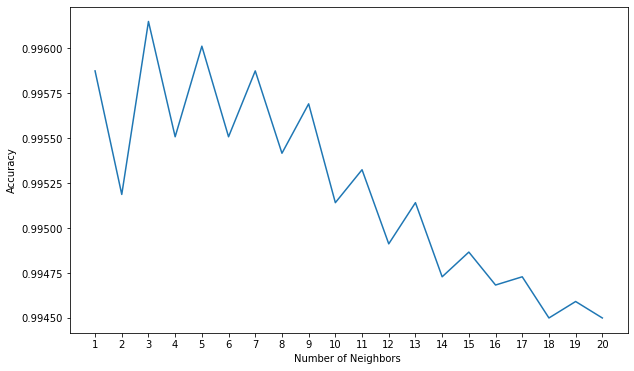

In [17]:
# calculating the accuracy of models with different values of k
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat= knn.predict(X_test)
    mean_acc[i-1] = accuracy_score(y_test, yhat)
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

In [18]:
grid_params = { 'n_neighbors' : [1,3,4],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

# fit the model on our train set
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [19]:
# find the best score
g_res.best_score_

0.9964637931684622

In [20]:
# get the hyperparameters with the best score
g_res.best_params_

{'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}

In [21]:
# use the best hyperparameters
knn_ = KNeighborsClassifier(n_neighbors = 3, weights = 'distance',metric = 'minkowski')
knn_.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [22]:
# get a prediction
y_hat = knn_.predict(X_train)
y_knn = knn_.predict(X_test)

Training set accuracy:  1.0
Test set accuracy:  0.9961037770443711
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8905
           1       0.99      1.00      0.99       576
           2       0.99      1.00      0.99      5598
           3       1.00      0.99      0.99      6737

    accuracy                           1.00     21816
   macro avg       0.99      1.00      1.00     21816
weighted avg       1.00      1.00      1.00     21816

Matrice de confusion:
(0) Eau
(1) Végétation
(2) Terrain nu
(3) Urbain)
Model accuracy:  0.9914189055225402


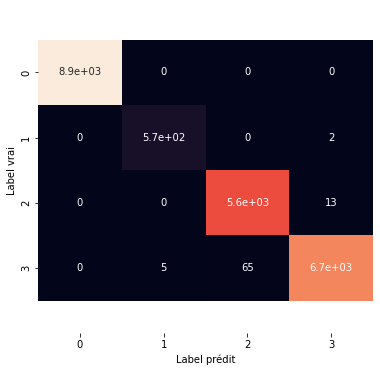

In [23]:
# Model Evaluation
print('Training set accuracy: ', accuracy_score(y_train, y_hat))
print('Test set accuracy: ',accuracy_score(y_test, y_knn))
print(classification_report(y_test, y_knn))
print("Matrice de confusion:")
plot_conf_mat(y_test, y_knn)
scores = cross_val_score(knn_, X, y, cv =5)
print('Model accuracy: ',np.mean(scores))

**COEFFICIENT KAPPA**

In [24]:
cohen_kappa_score(y_test, y_knn)

0.9941989612694511

**Résultat final**

In [25]:
full_ = knn_.predict(sentinel2)

In [26]:
full_ = full_.reshape([1 ,3527, 2996])

In [27]:
profile = src.profile
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

with rasterio.open('./out/output-2.tif', 'w', **profile) as dst:
    dst.write(full_.astype(rasterio.uint8))

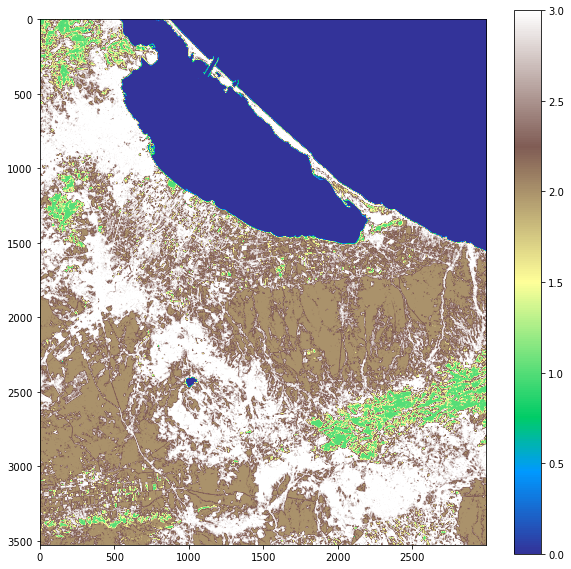

In [28]:
#open the raster
src=rasterio.open('./out/output-2.tif')

#display one band:
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(src.read(1), cmap='terrain')
fig.colorbar(img, ax=ax)

Même avec les paramètres optimales sur les données d'entrainement le résultat est presque le **même** (Voir gif ci-dessous).

<img src="./img/ezgif-3-478c20f5f241.gif">

### Exploration des signatures spectrales

Comme le montre l'image ci-dessous, on a un recouvrement entre la signature spectrale de l'urbain et celle du terrain nu.
Ce qui explique la confusion entre l'urbain et le terrain nu.

<img src="./img/Screenshot 2021-11-23 182001.png">

L'image ci-dessous montre qu'il y a des zones de terrain nu mais sont affectés par notre algorithme à la classe d'urbain et ceci est du dudit chevauchement.

<img src="./img/Screenshot 2021-11-23 182107.png">

## Biblio/Webo-graphie

* https://scikit-learn.org/ (Documentation)
* https://numpy.org/ (Documentation)
* https://pandas.pydata.org/ (Documentation)
* https://seaborn.pydata.org/ (Documentation)
* https://matplotlib.org/ (Documentation)
* https://rasterio.readthedocs.io/en/latest/ 
* https://www.kaggle.com/arunimsamudra/k-nn-with-hyperparameter-tuning
* https://semiautomaticclassificationmanual-v5.readthedocs.io/en/latest/tutorial_2.html#id1
* https://www.researchgate.net/figure/Spectral-Signature-Example-of-spectral-signature-plot_fig17_277075873